## Check Forecast Quality

- create csv files every day by running `get_forecast.ipynb`
- use this notebook to load all forecast of previous days and plot agains real stock prize of last week

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import yfinance as yf
 
class ForecastHandler:
    def __init__(self, company="nvidia", folder="."):
        self.company = company
        self.folder = folder
        self.forecasts = dict()
        self.forecast_files = [f for f in os.listdir(self.folder) if f.endswith(".csv") and company in f]
        print("found forecast files:", self.forecast_files)
 
    def load_all_forecasts(self):
        for forecast_file in self.forecast_files:
            date = forecast_file.split("_")[0]
            self.load_forecast(date)
 
    def load_forecast(self, date):
        filename = f'{date}_{self.company}_forecast.csv'
        print('load file '+filename)
        self.forecasts[date] = pd.read_csv(filename)
 
    def get_stock_price_series(self):
        ticker_symbol = self._company_to_ticker_mapping()[self.company]
        ticker_data = yf.Ticker(ticker_symbol)
        historical_data = ticker_data.history(period='7d')
        stock_prize = historical_data['Close']
        dates = []
        for date_i in historical_data.index:
            dates.append(pd.Timestamp(year=date_i.year, month=int(date_i.month), day=int(date_i.day)))
 
        #---### todo: dates.append(pd.Timestamp(year=current_year, month=int(day_month[1]), day=int(day_month[0])))
        #print(f"Current stock price of {self.company} is {current_price_usd} USD")
        return stock_prize, dates
 
    def _get_start_date(self, external_start_date):
        oldest_date = None
        for fc in self.forecasts:
            date = self.forecasts[fc]['date']
            if oldest_date is None or pd.Timestamp(date[0]) < oldest_date:
                oldest_date = pd.Timestamp(date[0])
        if external_start_date < oldest_date:
                oldest_date = external_start_date
        return oldest_date
 
    def plot_forecasts(self):
        current_stock_prize, current_stock_prize_dates = self.get_stock_price_series()
        idx_forecast_plot = 22
        plt.figure(figsize=(10, 6))
        for fc in self.forecasts:
            date = pd.to_datetime(self.forecasts[fc]['date'])
            print(date[0])
            forecast_list = self.forecasts[fc]['forecast']
            low = self.forecasts[fc]['low']
            high = self.forecasts[fc]['high']
            plt.plot(date,forecast_list,'o-', label=f'Forecast - {fc}', lw=2)
            #plt.plot(date[0], current_stock_prize, 'ro', label='Current Price')
            plt.fill_between(date,low, high, alpha=0.3, label='Confidence Interval')

            # Add labels and title
            plt.xlabel('Date')
            plt.ylabel('Price / USD')
            plt.title(f'{self.company} Forecast')
            plt.xticks(rotation=65)
            plt.legend()
            plt.grid(True)
            plt.title(f'{self.company} Forecast')
            #if range is not None:
        plt.xlim(pd.to_datetime(self._get_start_date(current_stock_prize_dates[0])), date[idx_forecast_plot])
        plt.ylim(0, max(max(current_stock_prize), max(forecast_list[0:idx_forecast_plot]))*1.4)
        #current_stock_prize_dates = [date.strftime('%Y-%m-%d') for date in current_stock_prize_dates]
        plt.plot(current_stock_prize_dates, current_stock_prize, 'ro-', label='Current Price')
        plt.minorticks_on()
        plt.grid(True, which='major', axis='both', color='gray', linestyle='-', linewidth=0.5)
        plt.grid(True, which='minor', axis='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
        # Show plot
        plt.tight_layout()
        plt.show()
 
    @staticmethod
    def _company_to_ticker_mapping():
        return {
            "nvidia": "NVDA",
            "apple": "AAPL",
            "amazon": "AMZN",
            "tesla": "TSLA",
            "microsoft": "MSFT",
            "rhm-aktie": "RHM.DE"
        }

found forecast files: ['20250312_nvidia_forecast.csv', '20250313_nvidia_forecast.csv', '20250315_nvidia_forecast.csv', '20250317_nvidia_forecast.csv', '20250318_nvidia_forecast.csv', '20250319_nvidia_forecast.csv']
load file 20250312_nvidia_forecast.csv
load file 20250313_nvidia_forecast.csv
load file 20250315_nvidia_forecast.csv
load file 20250317_nvidia_forecast.csv
load file 20250318_nvidia_forecast.csv
load file 20250319_nvidia_forecast.csv
2025-03-13 00:00:00
2025-03-13 00:00:00
2025-03-17 00:00:00
2025-03-18 00:00:00
2025-03-19 00:00:00
2025-03-20 00:00:00


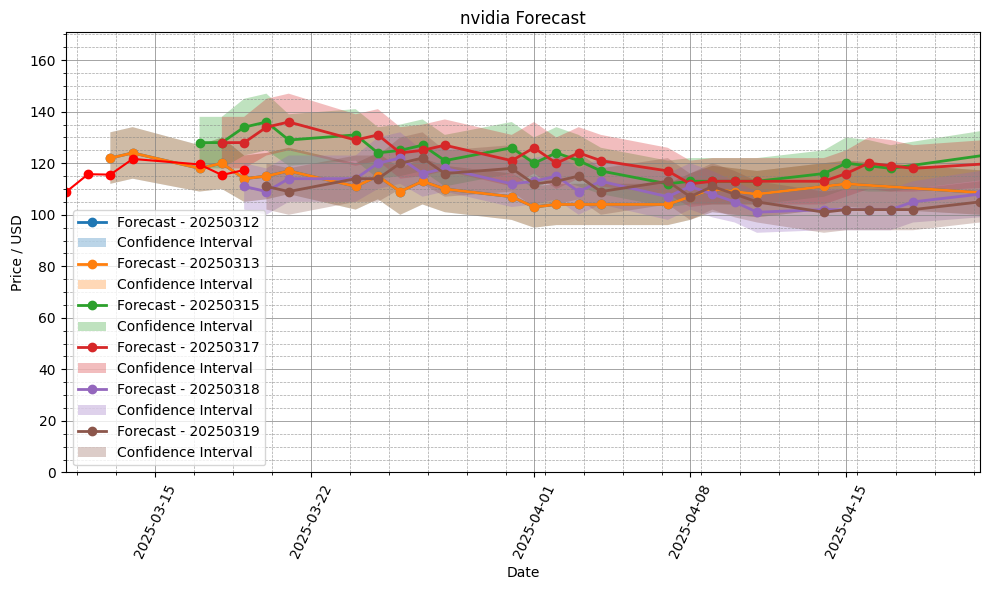

In [3]:
fh=ForecastHandler(company='nvidia')
fh.load_all_forecasts()
fh.plot_forecasts()

found forecast files: ['20250312_rhm-aktie_forecast.csv', '20250313_rhm-aktie_forecast.csv', '20250315_rhm-aktie_forecast.csv', '20250317_rhm-aktie_forecast.csv', '20250318_rhm-aktie_forecast.csv', '20250319_rhm-aktie_forecast.csv']
load file 20250312_rhm-aktie_forecast.csv
load file 20250313_rhm-aktie_forecast.csv
load file 20250315_rhm-aktie_forecast.csv
load file 20250317_rhm-aktie_forecast.csv
load file 20250318_rhm-aktie_forecast.csv
load file 20250319_rhm-aktie_forecast.csv
2025-03-13 00:00:00
2025-03-13 00:00:00
2025-03-17 00:00:00
2025-03-18 00:00:00
2025-03-19 00:00:00
2025-03-20 00:00:00


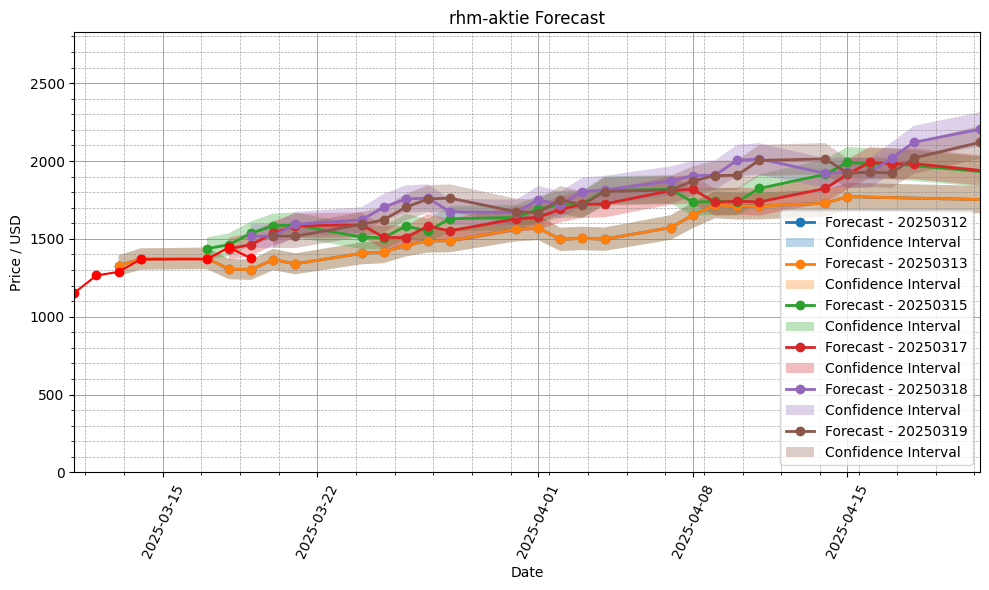

In [4]:
fh=ForecastHandler(company='rhm-aktie')
fh.load_all_forecasts()
fh.plot_forecasts()